In [1]:
import keras
from keras.models import load_model
import seaborn as sns
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.svm import SVR, LinearSVR
from matplotlib.ticker import FuncFormatter
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout
import pickle
import vaex

2023-08-13 21:07:55.188975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
FEATURES = ['trip_start_hour', 'trip_start_month',
       'trip_start_day', 'temp', 'humidity', 'wind_speed',
        'pressure', 'precip', 'Clear/Sunny',
       'Rain/Storms', 'Snow/Winter Conditions', 'temp_h-1', 'precip_h-1',
       'precip_h-2', 'autumn', 'spring', 'summer', 'winter', 'weekend',
       'afternoon_week', 'afternoon_weekend', 'evening_week',
       'evening_weekend', 'morning_week', 'morning_weekend', 'night_week',
       'night_weekend', 'is_holiday', 'demand_h-2', 'demand_h-24',
       'demand_p-24', 'demand_bucket_2', 'demand_bucket_6', 'demand_bucket_24',
       'catering', 'entertainment', 'transportation', 'healthcare', 'poi_sum',
       'is_airport', 'is_business_district']

TARGETS = ['demand_target_bucket_1', 'demand_target_bucket_2', 'demand_target_bucket_6', 'demand_target_bucket_24']

# Helper Functions

In order to test several set ups of the SVM, these helper functions were constructed to be used repeatedly.

* `get_X_y`: Takes a dataframe and returns the respective X and y vectors based on the prediction horizon which shall be the target feature. All other prediction horizons won't be included in the dataframe
* `scale_data`: Scales the data X_test and X_train data. To avoid leakage, we use the fitted scaler of the training data as well for the test data
* `plot_error_metric_per_horizon`: Plots model results of all Horizons per Resolution for each error metric
* `plot_r2_per_horizon`: Plots results of two dataframes to compare them in one plot for R2

In [3]:
def get_X_y(df, prediction_horizon):
    y = df[f'demand_target_bucket_{prediction_horizon}']
    X = df[FEATURES +[f'pickup_demand_target_bucket_{prediction_horizon}']]

    return X, y

In [4]:
def scale_data(X_train, X_test=None):
    # Create the scaler
    scaler = StandardScaler()

    # Fit the scaler using the training data
    scaler.fit(X_train)

    # Transform both the training and test data
    X_train_scaled = scaler.transform(X_train)
    if X_test is not None: # Explicitly check against None
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled
    return X_train_scaled

In [5]:
metrics = ['mse', 'mae', 'r2']
numbers = [2, 4, 6, 8, 0]
labels = ['2', '4', '6', '8', 'ct']

def plot_error_metric_per_horizon(df):
    plots, axes = plt.subplots(nrows = 3, ncols = 4, figsize = (20,10))
    plots.subplots_adjust(hspace=0.5, wspace= 0.3)
    horizons = df['horizon'].unique()
    i=0
    j=0
    for metric in metrics:
        for horizon in horizons:
            subset_df = df[df['horizon'] == horizon]
            sns.lineplot(ax=axes[i,j],x='resolution', y=metric, data=subset_df, marker='o')
            axes[i,j].set_title(f'Horizon {horizon}: {metric.upper()} vs Resolution')
            axes[i,j].set_xticks(numbers, labels)
            j=j+1
        j=0
        i=i+1
    plt.show()

In [6]:
def plot_r2_per_horizon(df_one, df_two ):
    plots, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (20,3))
    plots.subplots_adjust(hspace=0.3, wspace= 0.3)
    horizons = df_one['horizon'].unique()
    values_to_exclude = [0,6,7,8]
    df_one = df_one[~df_one['resolution'].isin(values_to_exclude)]
    j=0
    for horizon in horizons:
        subset_df_one = df_one[df_one['horizon'] == horizon]
        subset_df_two = df_two[df_two['horizon'] == horizon]
        sns.lineplot(ax=axes[j],x='resolution', y='r2', data=subset_df_one, marker='o', color = 'red', label = 'svm')
        sns.lineplot(ax=axes[j],x='resolution', y='r2', data=subset_df_two, marker='x', color = 'blue', label = 'nn')
        axes[j].set_title(f'Horizon {horizon}: R2 vs Resolution')
        axes[j].set_xticks(numbers, labels)
        axes[j].legend()
        j=j+1
    plt.show()


## Visualizing results

For this we first, want to take a look at each error metric (R2, MAE, MSE) for each approach (SVM, NN).

We want to plot the error for each prediction horizon with the error scale on the y axis and the number of resolutions on the x axis.

Through this we can compare the different resolutions in performance 

In [7]:
#import the results of the different resolutions and horizons
df_plot_results_svm = pd.read_csv('./data/results/svm_results.csv')
df_plot_results_nn = pd.read_csv('./data/results/NN_results.csv')

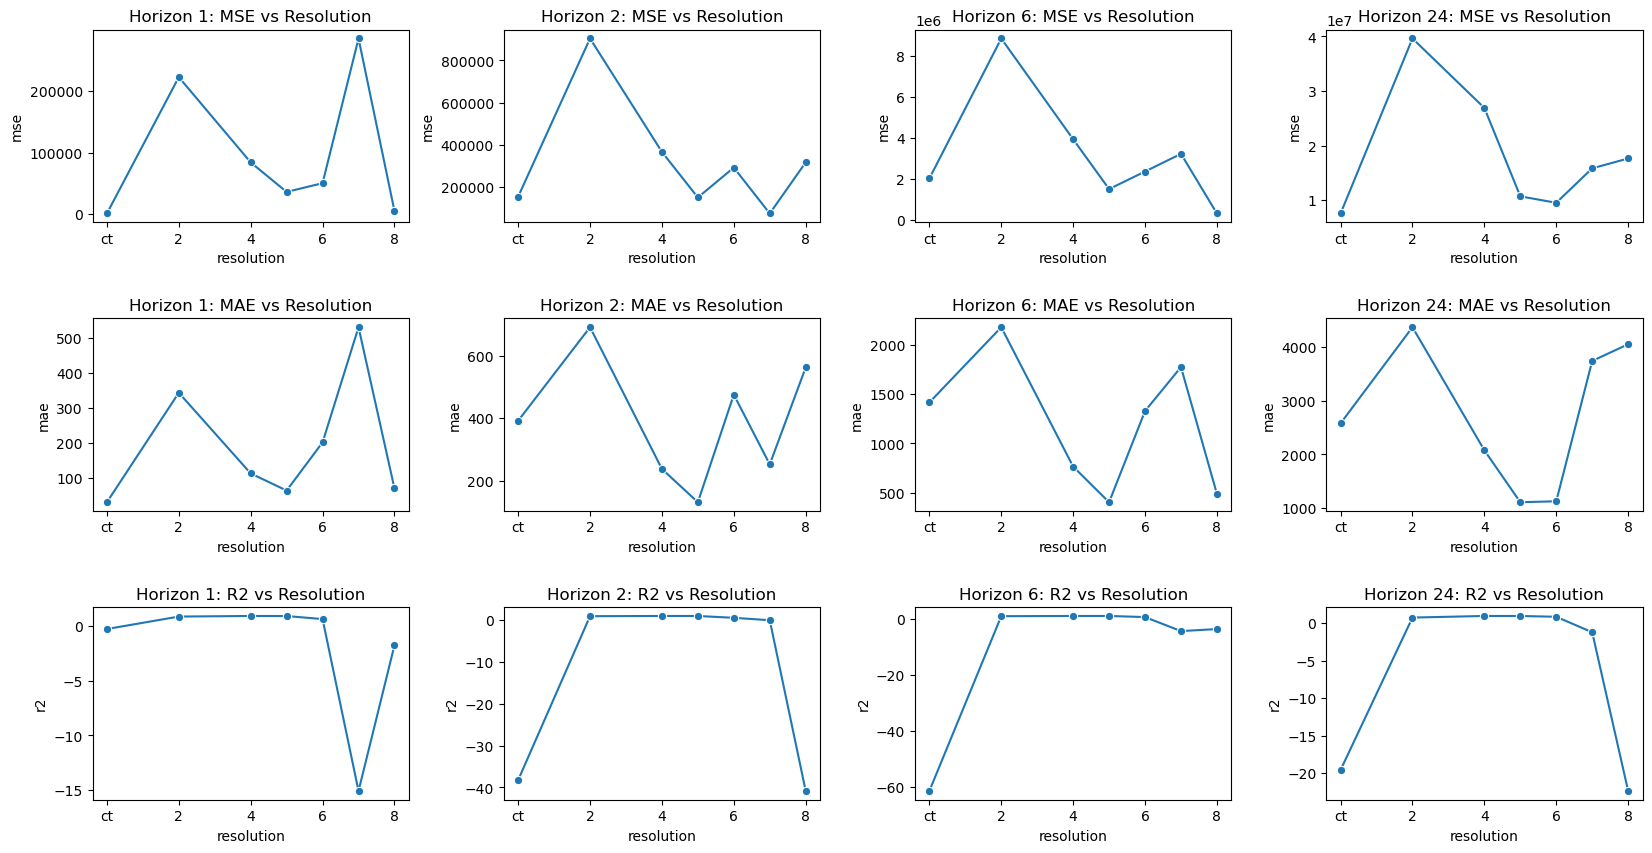

In [8]:
#plotting each error for all svm models
plot_error_metric_per_horizon(df_plot_results_svm)

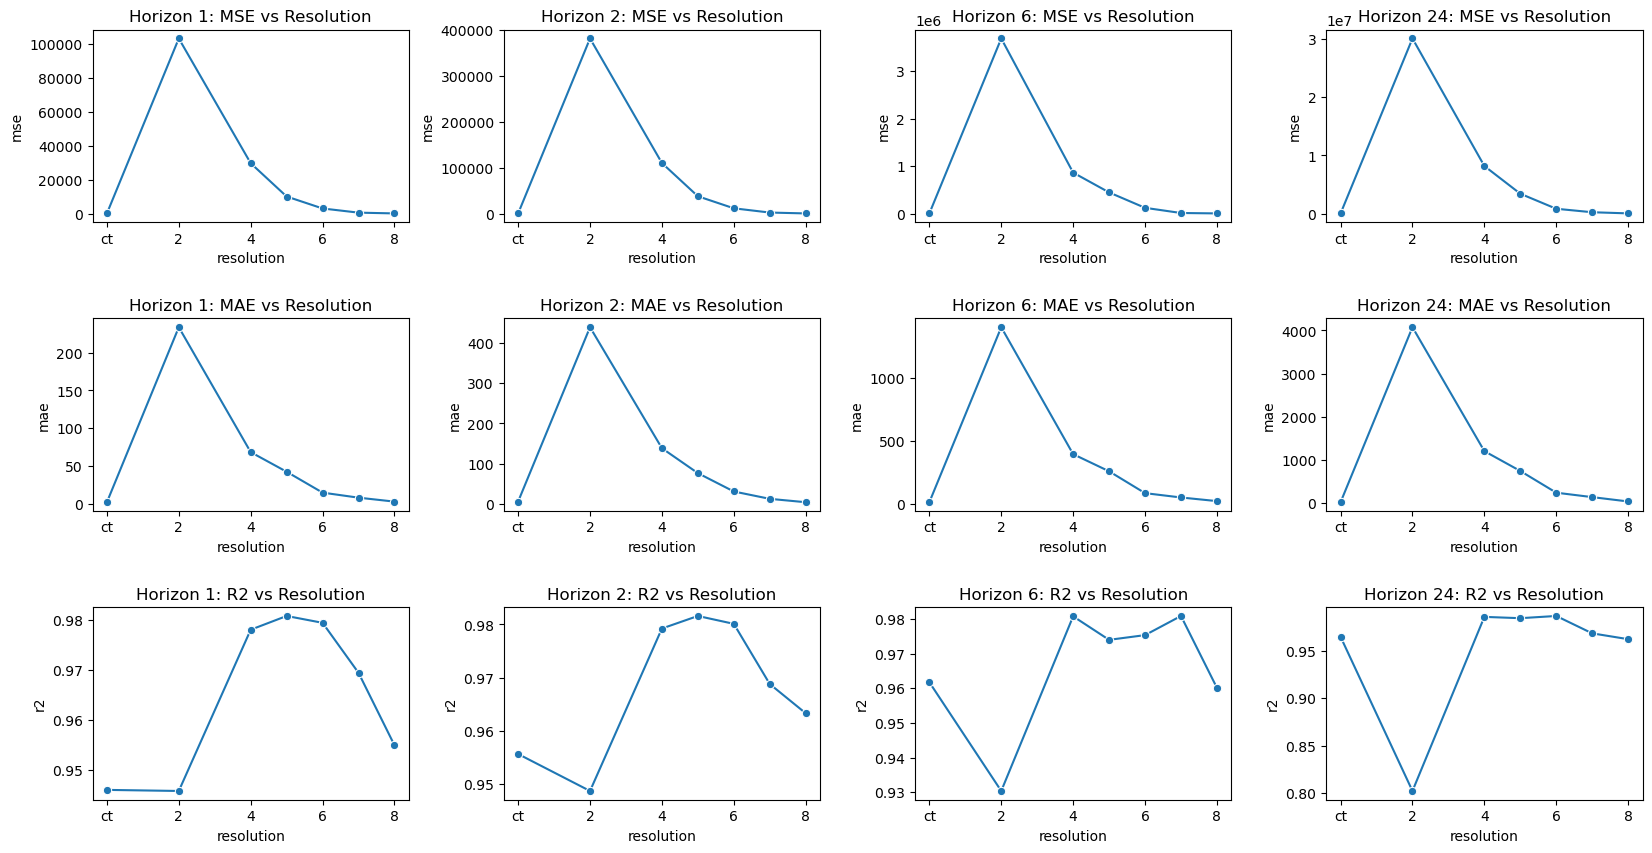

In [9]:
#plotting each error for all nn models
plot_error_metric_per_horizon(df_plot_results_nn)

Now we want to compare the model fit r2 for both NN and SVM in a single plot.

As can be seen in the plots above, the larger resolutions being 6,7,8 and cencus tract perform really bad, as they had to be executed with a limited amount of iterations. Therefore, we exclude them from this comparison and just look at how the best models of SVMs predictions hold up against the models of the NNs.

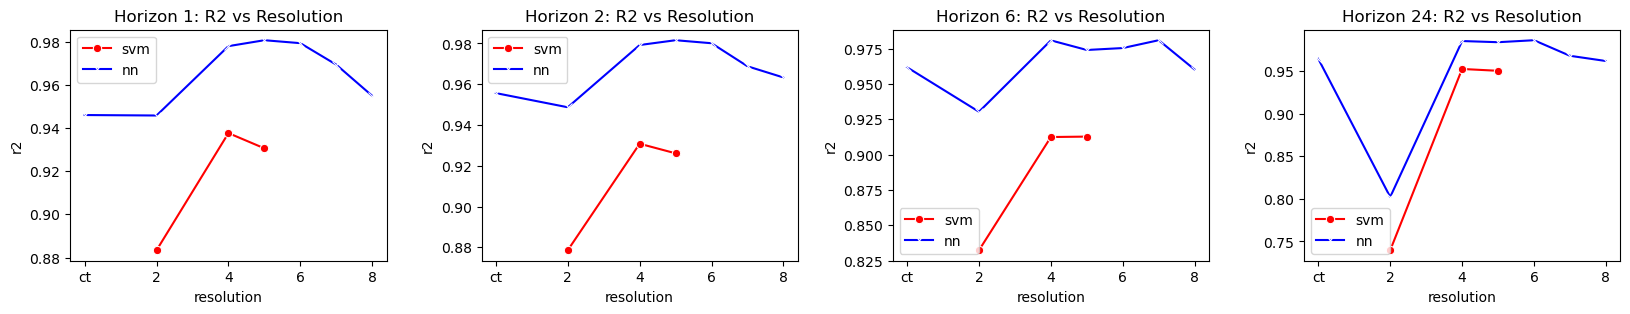

In [10]:
#plotting results of nn and svm regarding r2
plot_r2_per_horizon(df_plot_results_svm, df_plot_results_nn)

It is clear, that even the best SVM models, can not reach the prediction performance of the NN models. Even mor astouning, with the exception of the 24h prediction horizon, they can't even compare with the worst of the NN models. 

To highlight these results, we want to take a look at an actual prediction of both approaches. For this we pick the SVM model with the best model fit, the model with resolution 4. We use a test set, and plot the difference between the predicted demand and the actual demand.

In [127]:
#load svm model with ~best r2 performance for each horizon: res 4
model_1 = pickle.load(open('./data/SVM_checkpoints/4_res_1_target.pkl', 'rb'))
model_2 = pickle.load(open('./data/SVM_checkpoints/4_res_2_target.pkl', 'rb'))
model_6 = pickle.load(open('./data/SVM_checkpoints/4_res_6_target.pkl', 'rb'))
model_24 = pickle.load(open('./data/SVM_checkpoints/4_res_24_target.pkl', 'rb'))
df_data = pd.read_csv('./data/4_res_test.csv') #load test data

In [128]:
#make preditcion on test set
X_test_1, y_test_1 = get_X_y(df_data, 1)
X_test_scaled_1= scale_data(X_test_1)

X_test_2, y_test_2 = get_X_y(df_data, 2)
X_test_scaled_2= scale_data(X_test_2)

X_test_6, y_test_6 = get_X_y(df_data, 6)
X_test_scaled_6= scale_data(X_test_6)

X_test_24, y_test_24 = get_X_y(df_data, 24)
X_test_scaled_24= scale_data(X_test_24)

y_pred_1 = model_1.predict(X_test_scaled_1)
y_pred_2 = model_2.predict(X_test_scaled_2)
y_pred_6 = model_6.predict(X_test_scaled_6)
y_pred_24 = model_24.predict(X_test_scaled_24)

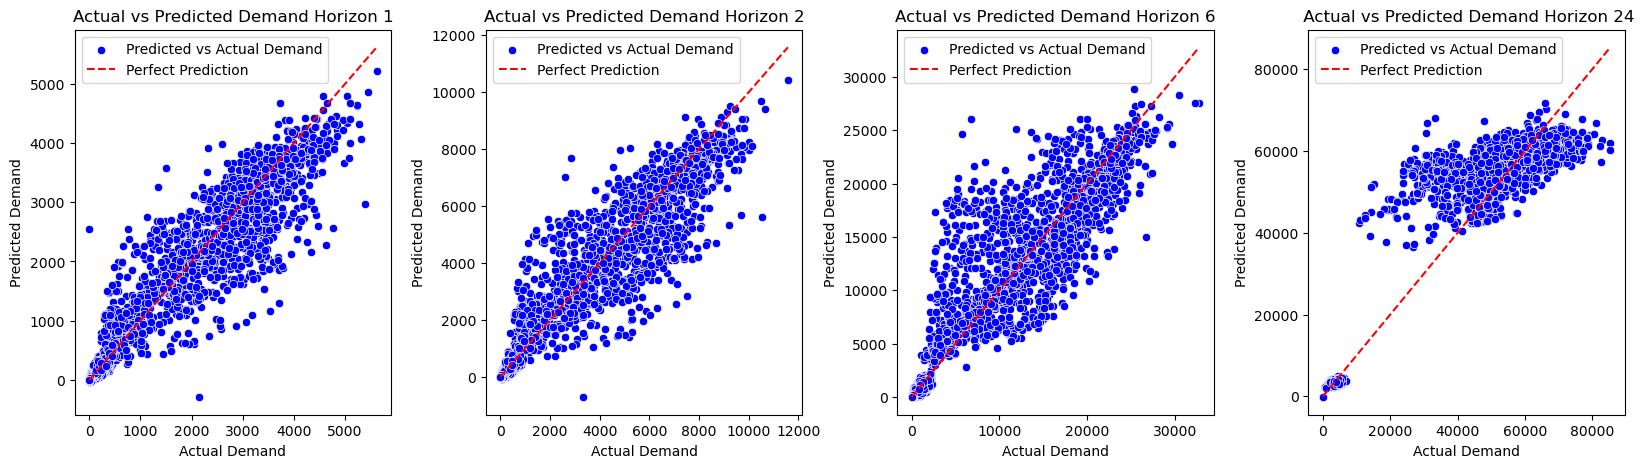

In [136]:
plots, axes = plt.subplots(nrows = 1, ncols = 4, figsize =(20, 5))
plt.subplots_adjust(wspace=0.3)
sns.scatterplot(ax=axes[0], x = y_test_1, y = y_pred_1, color='blue', label='Predicted vs Actual Demand')
axes[0].plot([min(y_test_1), max(y_test_1)], [min(y_test_1), max(y_test_1)], linestyle='--', color='red', label='Perfect Prediction')
sns.scatterplot(ax=axes[1], x = y_test_2, y = y_pred_2, color='blue', label='Predicted vs Actual Demand')
axes[1].plot([min(y_test_2), max(y_test_2)], [min(y_test_2), max(y_test_2)], linestyle='--', color='red', label='Perfect Prediction')
sns.scatterplot(ax=axes[2], x = y_test_6, y = y_pred_6, color='blue', label='Predicted vs Actual Demand')
axes[2].plot([min(y_test_6), max(y_test_6)], [min(y_test_6), max(y_test_6)], linestyle='--', color='red', label='Perfect Prediction')
sns.scatterplot(ax=axes[3], x = y_test_24, y = y_pred_24, color='blue', label='Predicted vs Actual Demand')
axes[3].plot([min(y_test_24), max(y_test_24)], [min(y_test_24), max(y_test_24)], linestyle='--', color='red', label='Perfect Prediction')

axes[0].set_title('Actual vs Predicted Demand Horizon 1')
axes[1].set_title('Actual vs Predicted Demand Horizon 2')
axes[2].set_title('Actual vs Predicted Demand Horizon 6')
axes[3].set_title(' Actual vs Predicted Demand Horizon 24')

axes[0].set_xlabel('Actual Demand')
axes[0].set_ylabel('Predicted Demand')
axes[1].set_xlabel('Actual Demand')
axes[1].set_ylabel('Predicted Demand')
axes[2].set_xlabel('Actual Demand')
axes[2].set_ylabel('Predicted Demand')
axes[3].set_xlabel('Actual Demand')
axes[3].set_ylabel('Predicted Demand')

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()


plt.show()

For a smaller horizon the prediction is fairly accurate, but the larger the horizon gets the more spreach out the predictions become. Especially, for 24 hours the prediction is not very accurate at all. 

In [115]:
#for better comparison we also load the res 4 model of nn, even though it is not clear which model exactly performs the best for the nn models
model_1_nn = load_model('./data/NN_checkpoints/5_res_1_target.h5')
model_2_nn = load_model('./data/NN_checkpoints/5_res_2_target.h5')
model_6_nn = load_model('./data/NN_checkpoints/5_res_6_target.h5')
model_24_nn = load_model('./data/NN_checkpoints/5_res_24_target.h5')
df_data = pd.read_csv('./data/5_res_test.csv') #load test data

In [116]:
#make preditcion on test set
X_test_1_nn, y_test_1_nn = get_X_y(df_data, 1)
X_test_scaled_1_nn= scale_data(X_test_1_nn)

X_test_2_nn, y_test_2_nn = get_X_y(df_data, 2)
X_test_scaled_2_nn= scale_data(X_test_2_nn)

X_test_6_nn, y_test_6_nn = get_X_y(df_data, 6)
X_test_scaled_6_nn= scale_data(X_test_6_nn)

X_test_24_nn, y_test_24_nn = get_X_y(df_data, 24)
X_test_scaled_24_nn= scale_data(X_test_24_nn)

y_pred_1_nn = model_1.predict(X_test_scaled_1_nn)
y_pred_2_nn = model_2.predict(X_test_scaled_2_nn)
y_pred_6_nn = model_6.predict(X_test_scaled_6_nn)
y_pred_24_nn = model_24.predict(X_test_scaled_24_nn)

437/437 [==============================] - 1s 1ms/step


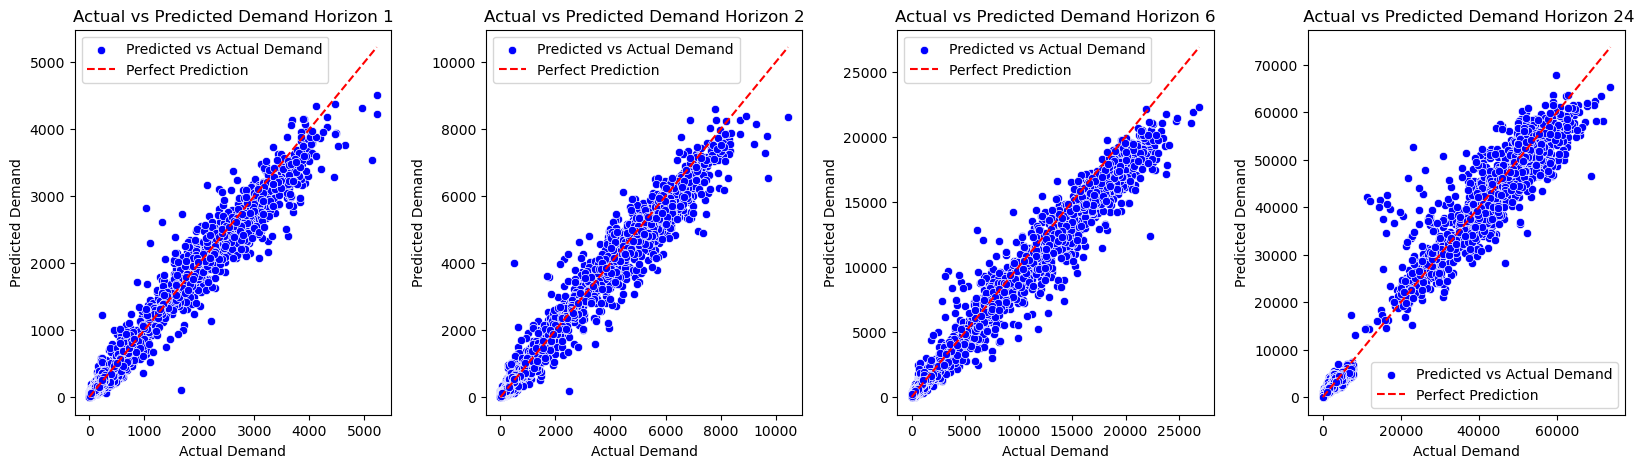

In [150]:
plots, axes = plt.subplots(nrows = 1, ncols = 4, figsize =(20, 5))
plt.subplots_adjust(wspace=0.3)
sns.scatterplot(ax=axes[0], x = y_test_1_nn, y = y_pred_1_nn[:, 0], color='blue', label='Predicted vs Actual Demand')
axes[0].plot([min(y_test_1_nn), max(y_test_1_nn)], [min(y_test_1_nn), max(y_test_1_nn)], linestyle='--', color='red', label='Perfect Prediction')
sns.scatterplot(ax=axes[1], x = y_test_2_nn, y = y_pred_2_nn[:, 0], color='blue', label='Predicted vs Actual Demand')
axes[1].plot([min(y_test_2_nn), max(y_test_2_nn)], [min(y_test_2_nn), max(y_test_2_nn)], linestyle='--', color='red', label='Perfect Prediction')
sns.scatterplot(ax=axes[2], x = y_test_6_nn, y = y_pred_6_nn[:, 0], color='blue', label='Predicted vs Actual Demand')
axes[2].plot([min(y_test_6_nn), max(y_test_6_nn)], [min(y_test_6_nn), max(y_test_6_nn)], linestyle='--', color='red', label='Perfect Prediction')
sns.scatterplot(ax=axes[3], x = y_test_24_nn, y = y_pred_24_nn[:, 0], color='blue', label='Predicted vs Actual Demand')
axes[3].plot([min(y_test_24_nn), max(y_test_24_nn)], [min(y_test_24_nn), max(y_test_24_nn)], linestyle='--', color='red', label='Perfect Prediction')

axes[0].set_title('Actual vs Predicted Demand Horizon 1')
axes[1].set_title('Actual vs Predicted Demand Horizon 2')
axes[2].set_title('Actual vs Predicted Demand Horizon 6')
axes[3].set_title(' Actual vs Predicted Demand Horizon 24')

axes[0].set_xlabel('Actual Demand')
axes[0].set_ylabel('Predicted Demand')
axes[1].set_xlabel('Actual Demand')
axes[1].set_ylabel('Predicted Demand')
axes[2].set_xlabel('Actual Demand')
axes[2].set_ylabel('Predicted Demand')
axes[3].set_xlabel('Actual Demand')
axes[3].set_ylabel('Predicted Demand')

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()


plt.show()

When comparing both models on an actual test set, it becomes clear how much more accurate our NN model is compare to the SVM model. 

Not only is the overall error smaller, which is shown in the closeness to the perfect prediciton line in the plots, but bigger predicition horizons do not worsen the NN models predictions like they do for the SVM model. 